# Предсказание временных рядов

## Введение. Постановка целей и задач.



---


**Введение:**


*Выбранный датасет Restaurant Visitors относится к ресторанному бизнесу и содержит данные о посещаемости ресторанов. Анализ данной темы интересен для бизнеса, так как позволяет решить следующие задачи:*
- Оценка количества посещаемости каждого ресторана, можно сделать вывод какой ресторан посещают чаще, какой реже;
- Анализ взаимосвязи посещаемости каждого ресторана от дня недели, можно сделать вывод в какие дни недели рестораны посещают чаще, в какие реже.
- Возможность прогнозирования позволяет планировать развитие на будущее или наоборот отслеживать негативные тренды.*

---



---


**Цель:**


*Проведение исследования данных о посещаемости ресторанов, выявление зависимости посещаемости от дней недели и построение прогноза посещаемости на несколько дней.*

---



**Задачи:**

*Основные:*
- задача 1. подтвердить зависимость посещаемости от дня недели;
- задача 2. получить прогноз на 2 недели вперед.

*Дополнительные:*

*Обработать данные и отфильтровать необходимую информацию, определить основные метрики, произвести расчет основных стат. показателей, проверить возможные кореляции метрик/атрибутов, проверить выбранные модели на предмет возможности и качества прогнозирования, получить прогнозы и сделать выводы.* 

---



### Импорт Датафрейма, библиотек, написание функций.

*Импортируем всё, что нам нужно для работы: библиотеки, отдельные функции, сам датасет.*

In [1]:
# Импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Установка pmdarima и  fbprophet  
!pip install pmdarima                                        # загружаем pmdarima
!pip install fbprophet                                       # загружаем fbprophet

# Импортируем модели
from statsmodels.tsa.statespace.sarimax import SARIMAX       # импорт модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей
from fbprophet import Prophet                                # для модели Профет
import statsmodels.tsa
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # для модели Экспоненцальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений (опционально)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загружаем исследуемый датасет
df=pd.read_csv('/content/RestaurantVisitors.csv')

In [3]:
# Проверяем, что датасет загрузился корректно
df.head()

,date,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
0,1/1/2016,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
1,1/2/2016,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2,1/3/2016,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
3,1/4/2016,Monday,0,na,23.0,18.0,32.0,32.0,105.0
4,1/5/2016,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


### Знакомство с данными.

In [4]:
# Изучаем общую информацию по исходному датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          517 non-null    object 
 1   weekday       517 non-null    object 
 2   holiday       517 non-null    int64  
 3   holiday_name  517 non-null    object 
 4   rest1         478 non-null    float64
 5   rest2         478 non-null    float64
 6   rest3         478 non-null    float64
 7   rest4         478 non-null    float64
 8   total         478 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 36.5+ KB



### Промежуточные выводы:

---


*При первом просмотре датасета получаем следующую информацию:* 

*Датасет содержит данные по посещаемости условной сети ресторанов, включающей четыре заведения. Период сбора данных с января 2016 по май 2017 года. Дополнительно датасет содержит сведения по праздничным дням.*

*Датасет включает 9 атрибутов:*

*   date - дата наблюдения 
*   weekday - название дня недели
*   holiday - указание праздничного дня (да/нет)
*   holiday_name - название праздника
*   rest1-rest4 - посещаемость каждого из 4х ресторанов (кол-во человек/день) 
*   total - общая посещаемость по всем 4м ресторанам (кол-во человек/день)

*Общее количество строк - 517. При этом у атрибутов rest1-rest4 и total только 478 строк имеют значения.*

*Тип колонок:*

*   date, weekday, holiday_name - object 
*   holiday - int64
*   rest1-rest4, total - float 64

*Для дальнейшей работы с датасетом будет необходимо преобразовать типы данных атрибутов date, weekday для корректного считывания и отображения.*


---



---


*По результатам первичного анализа датасета в качестве основных метрик для задачи 1 могут быть выбраны:*

*   rest1-rest4 - посещаемость по ресторанам 1-4 (кол-во человек/день)
*   total - общая посещаемость всех ресторанов (кол-во человек/день)

*В качестве прогнозной метрики для решения поставленой задачи 2 подходит  метрика total.*


---

## Предобработка данных

### Фильтрация данных



---


*Для решения поставленных задач наш датасет содержит избыточные данные, которые необходимо удалить перед дальнейшим анализом.* 
*Такими данными в нашем случае являются атрибуты holiday и holiday_name с названиями праздничных дней.*


---



In [5]:
# Исключаем атрибут holiday и holiday_name из датасета используя метод drop
df_filt=df.drop(['holiday','holiday_name'],axis=1)
# Проверяем результат
df_filt.head()

,date,weekday,rest1,rest2,rest3,rest4,total
0,1/1/2016,Friday,65.0,25.0,67.0,139.0,296.0
1,1/2/2016,Saturday,24.0,39.0,43.0,85.0,191.0
2,1/3/2016,Sunday,24.0,31.0,66.0,81.0,202.0
3,1/4/2016,Monday,23.0,18.0,32.0,32.0,105.0
4,1/5/2016,Tuesday,2.0,15.0,38.0,43.0,98.0


### Обработка пропусков



---


*По предварительному анализу датасет содержит атрибуты с пропусками данных (rest1-rest4 и total имеют 478 значений из 517). Предположим, что пропуски (NaN) связаны с недоступностью данных на определенный день, можно считать в такие дни, что соответствующий показатель = 0.*

*Разложим анализ пропусков на две под-задачи:*

*   проверим датасет на предмет отсутствующих дат/дней для исключения разрывов на всем интервале наблюдений; 
*   найдем пропуски в значениях переменных и заменим их на 0. 


---



In [6]:
# Переопределяем тип атрибута date (из object в datetime64) как дата для дальнейшей обработки
df_filt['date'] = pd.to_datetime(df_filt['date'])
# Проверяем результат
df_filt.dtypes

date       datetime64[ns]
weekday            object
rest1             float64
rest2             float64
rest3             float64
rest4             float64
total             float64
dtype: object

In [7]:
# Сортируем атрибут date по датам, для исключения несоответствия распределения дат в датасете
df_filt_sort = df_filt.sort_values(by='date')
# Проверяем результат
df_filt_sort

,date,weekday,rest1,rest2,rest3,rest4,total
0,2016-01-01,Friday,65.0,25.0,67.0,139.0,296.0
1,2016-01-02,Saturday,24.0,39.0,43.0,85.0,191.0
2,2016-01-03,Sunday,24.0,31.0,66.0,81.0,202.0
3,2016-01-04,Monday,23.0,18.0,32.0,32.0,105.0
4,2016-01-05,Tuesday,2.0,15.0,38.0,43.0,98.0
...,...,...,...,...,...,...,...
512,2017-05-27,Saturday,NaN,NaN,NaN,NaN,NaN
513,2017-05-28,Sunday,NaN,NaN,NaN,NaN,NaN
514,2017-05-29,Monday,NaN,NaN,NaN,NaN,NaN
515,2017-05-30,Tuesday,NaN,NaN,NaN,NaN,NaN


In [8]:
# Проверяем наличие отсутствующих дат в интервале наблюдений по датасету
start_date = min(df_filt['date'])    # дата начала интервала наблюдений
end_date = max(df_filt['date'])      # дата конца интервала наблюдений
dates_list= df_filt_sort['date'].tolist()    # получение списка всех дат по датасету
dates_list_count = 0     # счетчик нахождения даты по датасету во всем интервале
dates_lose_count = 0     # счетчик отсутствия даты по датасету во всем интервале

for i in pd.date_range(start=start_date, end=end_date):
    if i in dates_list: 
      dates_list_count = dates_list_count + 1
    else: 
      dates_lose_count = dates_lose_count + 1
      
print ('Дата начала наблюдений по датасету:', start_date)
print ('Дата конца наблюдений по датасету:', end_date)
print ('Общее кол-во дат/дней за весь интервал наблюдений:', len(pd.date_range(start=start_date, end=end_date)))
print ('Кол-во дат/дней по датасету:', dates_list_count)
print ('Кол-во отсутствующих дат/дней по датасету:', dates_lose_count)

Дата начала наблюдений по датасету: 2016-01-01 00:00:00
Дата конца наблюдений по датасету: 2017-05-31 00:00:00
Общее кол-во дат/дней за весь интервал наблюдений: 517
Кол-во дат/дней по датасету: 517
Кол-во отсутствующих дат/дней по датасету: 0


In [9]:
# Проверяем наличие пропусков в каждом атрибуте (False - нет пропусков, True - есть пропуски)
df_filt_sort.isna().value_counts()

date   weekday  rest1  rest2  rest3  rest4  total
False  False    False  False  False  False  False    478
                True   True   True   True   True      39
dtype: int64

In [10]:
# Заменяем пропуски на 0
df_filt_sort2 = df_filt_sort.fillna(0)
# Проверяем результат
df_filt_sort2

,date,weekday,rest1,rest2,rest3,rest4,total
0,2016-01-01,Friday,65.0,25.0,67.0,139.0,296.0
1,2016-01-02,Saturday,24.0,39.0,43.0,85.0,191.0
2,2016-01-03,Sunday,24.0,31.0,66.0,81.0,202.0
3,2016-01-04,Monday,23.0,18.0,32.0,32.0,105.0
4,2016-01-05,Tuesday,2.0,15.0,38.0,43.0,98.0
...,...,...,...,...,...,...,...
512,2017-05-27,Saturday,0.0,0.0,0.0,0.0,0.0
513,2017-05-28,Sunday,0.0,0.0,0.0,0.0,0.0
514,2017-05-29,Monday,0.0,0.0,0.0,0.0,0.0
515,2017-05-30,Tuesday,0.0,0.0,0.0,0.0,0.0


In [11]:
# Переопределяем тип атрибута weekday (из object в string) для корректного считывания и отображения
df_filt_sort2[['weekday']] = df_filt_sort2[['weekday']].astype('string')
# Проверяем результат
df_filt_sort2.dtypes

date       datetime64[ns]
weekday            string
rest1             float64
rest2             float64
rest3             float64
rest4             float64
total             float64
dtype: object

### Промежуточные выводы:


---


*При работе с исходным датасетом произвели следующие действия:*

*1) Оставили в датасете только те колонки, которые будем использовать для дальнейшего анализа и отсортировали по дате.*

*2) Преобразовали типы данных колонок date и weekday в datetime64 и string соответственно для корректного считывания и отображения*

*3) Проверили наличие отсутствующих дат. Подобных дат не выявлено, интервал наблюдений без разрывов.*

*4) Проверили датасет на наличие пропусков. Выявлено 39 пропусков по атрибутам rest1-4 и total. Пропуски заменены на 0.*

*После произведенных действий данный датасет пригоден для перехода к следующему этапу.*


---



## EDA (exploratory data analysis) или разведочный анализ данных.


---


*На данном этапе изучим датасет на предмет:*

*   получение статистических данных; 
*   построение графиков для обозначенных метрик и распределений;
*   попробуем выявить взаимосвязи между атрибутами. 

---



In [12]:
# Преобразуем атрибут date в индексы для формирования временного ряда
df_eda = df_filt_sort2.set_index('date')
# Проверяем результат
df_eda.head()

,weekday,rest1,rest2,rest3,rest4,total
date,,,,,,
2016-01-01,Friday,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,2.0,15.0,38.0,43.0,98.0


In [13]:
# Выводим статистику по атрибутам
round(df_eda.describe(),2)

,rest1,rest2,rest3,rest4,total
count,517.00,517.00,517.00,517.00,517.00
mean,34.70,25.11,29.17,34.72,123.70
std,22.93,16.74,19.06,25.66,67.45
min,0.00,0.00,0.00,0.00,0.00
25%,20.00,12.00,17.00,16.00,77.00
50%,32.00,23.00,23.00,28.00,111.00
75%,48.00,37.00,43.00,49.00,171.00
max,128.00,91.00,99.00,139.00,316.00


In [14]:
# Посмотрим суммарно сколько раз посещали тот или иной ресторан за весь интервал наблюдений
Total = round(df_eda['rest1'].sum())
print ("Visitors rest1 sum:",Total)
Total = round(df_eda['rest2'].sum())
print ("Visitors rest2 sum:",Total)
Total = round(df_eda['rest3'].sum())
print ("Visitors rest3 sum:",Total)
Total = round(df_eda['rest4'].sum())
print ("Visitors rest4 sum:",Total)

Visitors rest1 sum: 17941
Visitors rest2 sum: 12984
Visitors rest3 sum: 15080
Visitors rest4 sum: 17948


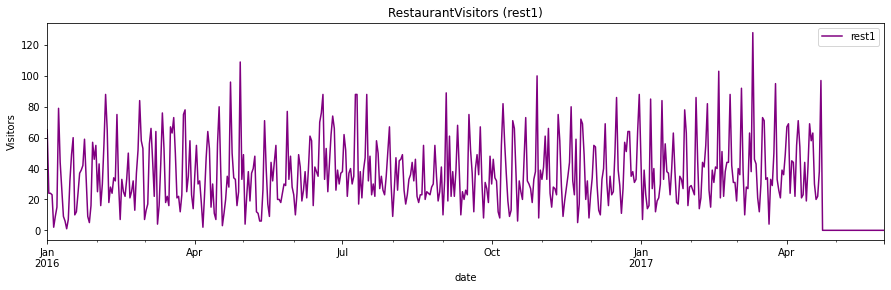

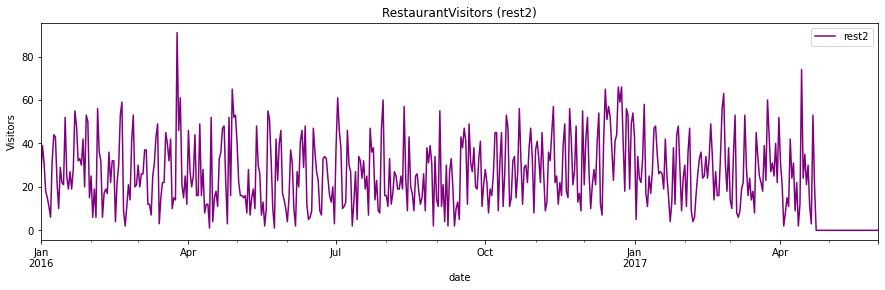

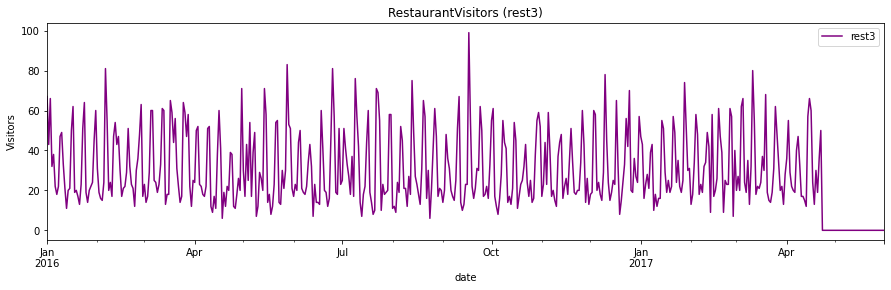

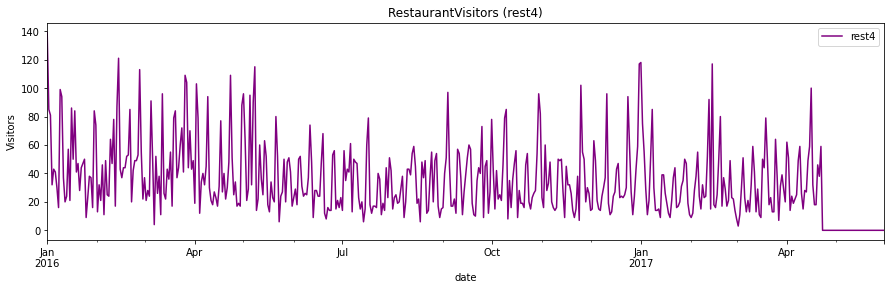

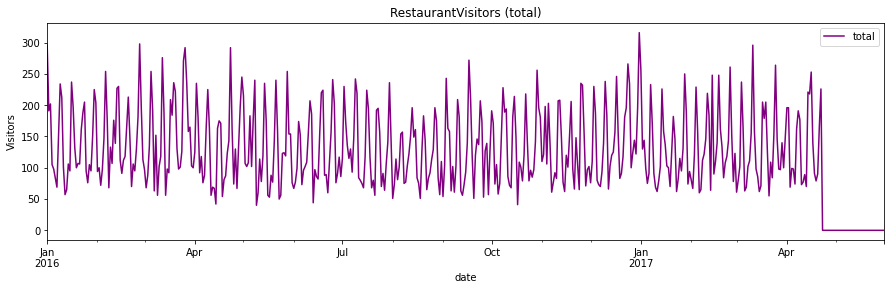

In [15]:
# Построим графики для метрик
# Для этого создадим новый датасет только с атрибутами метрик
df_eda_metric=df_eda.drop(['weekday'],axis=1)

for i in df_eda_metric.columns:
    df_eda_graph=df_eda_metric[i].plot(figsize=(15,4), legend=True, ylabel='Visitors', color = 'purple', title=f'RestaurantVisitors ({i})')
    df_eda_graph.autoscale(axis='x', tight=True)
    plt.show() 



---


*Промежуточные выводы:*

*За рассматриваемый период 2016.01 - 2017.05 чаще всего посещали ресторан №4 (17948 посещаний) и ресторан №1 (17941 посещений). Реже всего посещали ресторан №2 (12984 посещений).*

*Максимальное количество посетителей в день было у ресторана №4 и составило 139 человек, у ресторана 1 - 131 человек, у ресторана 3 - 99 человек и у ресторана 2 - 91 человек.*

*По графикам видно, что наблюдается недельная сезонность, предположительно связанная с более высокой посещаемостью в выходные дни.*

*По графикам также четко отслеживается ситуация с пропусками данных, замененных ранее на нули. Данные пропуски располагаются в конце датасета и по факту не связаны с наблюдаемыми значениями. Поэтому в дальнейшем на этапе прогнозирования необходимо исключить данный "нулевой хвост" для более корректного результата по моделям.* 

---



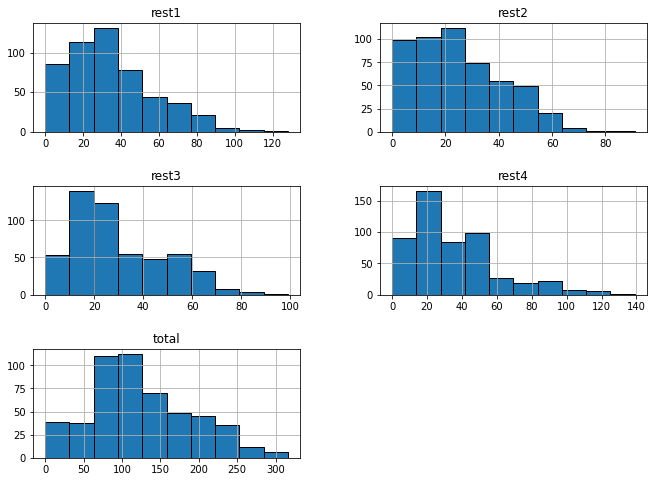

In [16]:
# Построим гистограммы для определения распределения данных
df_eda_graph2 = df_eda_metric.hist(edgecolor = 'k', figsize=([11,8]))
plt.subplots_adjust(wspace=0.3, hspace=0.5);

### Промежуточные выводы:


---


*Полученные гистограммы показывают ненормальное распределение и позволяют сделать следующие выводы:*

*1) Среднее кол-во посетителей по ресторанам примерно одинаковое без аномальной разницы по пикам.*

*2) Ресторан 4 выделяется на фоне остальных более стабильным кол-вом посещений. Можно сделать вывод, что этот ресторан пользуется большим спросом.*

---

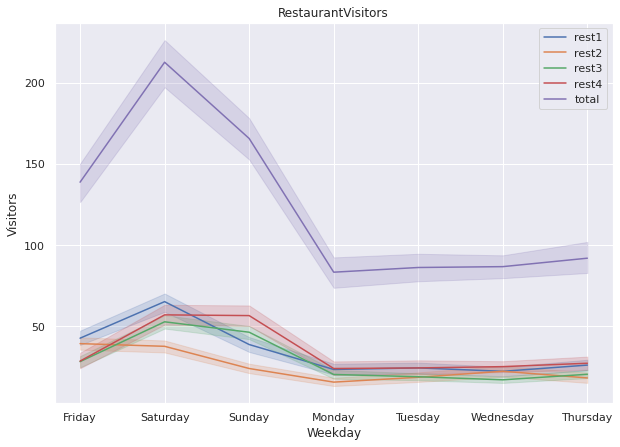

In [17]:
# построим графики зависимости количества посетителей от дня недели
sns.set(rc={'figure.figsize':(10,7)})

for i in df_eda_metric.columns:
    sns.lineplot(data = df_eda, x = 'weekday', y = f'{i}', label=str(i))
plt.title('RestaurantVisitors')
plt.xlabel('Weekday')
plt.ylabel('Visitors');

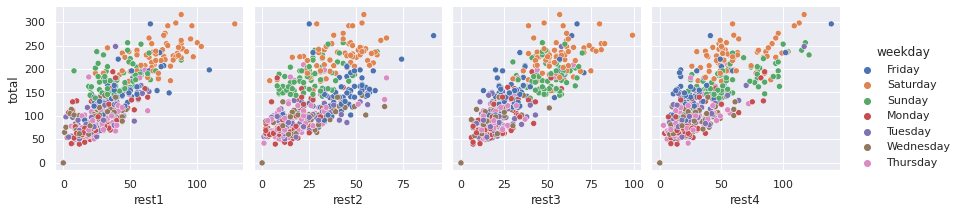

In [18]:
# Pairplot сопоставляет все переменные со всеми (используем для выявления кореляции)
# График зависимости количества посетителей каждого ресторана от суммарного количества в зависимости от дня недели
sns.pairplot(df_eda, hue="weekday", x_vars=["rest1", "rest2", "rest3", "rest4"], y_vars=["total"], height=3);

### Промежуточные выводы:


---


*По данным графикам прослеживается корреляция посещаемости от дня недели. Видно, что рост посещаемости приходится на пятницу-воскресенье с пиком в субботу. Таким образом задача 1 подтверждена.*


---


## Построение моделей, анализ результатов.

---


*На данном этапе проведем исследование по второй поставленной задаче - прогнозирование общей посещаемости ресторанов (метрика total). Здесь нам потребуется:*

*   определится с кол-вом прогнозируемых дней, возьмем 2 недели для более наглядного результата прогноза; 
*   разделить наш датасет на тренировочную и тестовую выборки, тренировочную используем для обучения моделей, а тестовую для проверки точности выполненного прогноза;
*   определится с моделями прогнозирования, здесь выберем 3 модели - в качестве основной используем SARIMAX, поскольку у нас явно выраженная сезонность, также проверим на нашем датасете работу моделей Prophet и Экспоненциальное сглаживание для выявления возможно более точных результатов предсказаний. 
*   в завершении обучим наши модели, получим прогнозные данные и сравним с тестовой выборкой. 


---


---

*На предыдущих этапах был выявлен "хвост" с нулевыми значениями - 39 строк в конце датасета для атрибутов/метрик rest1-4 и total. Для корректной выборки данных обучающей и тестовой групп, и как следствие для более реального прогноза, создадим новый датасет не включающий последние нулевые строки.* 


---


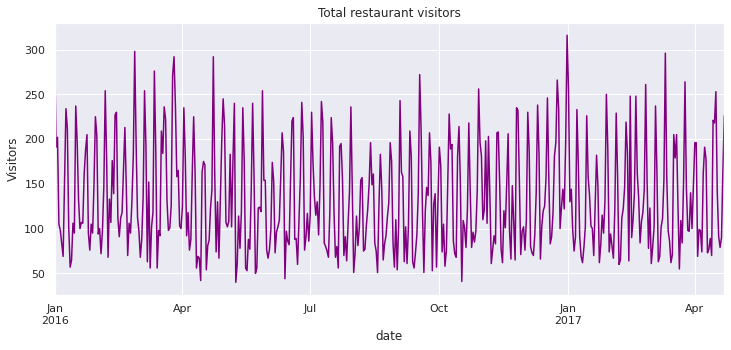

In [19]:
# Подготовим данные для прогнозирования
# Создаем новый датасет без учета последних 39 строк (нулевые значения)
df_eda_nn = df_eda.iloc[:len(df)-39]
# Проверяем отсутсвие "нулевого хвоста" на примере графика total/visitors:
df_eda_graph3=df_eda_nn['total'].plot(figsize=(12,5), title='Total restaurant visitors', ylabel='Visitors', color='purple')
df_eda_graph3.autoscale(axis='x', tight=True)

In [20]:
# Разделим данные на обучающую и тестовую выборки (train/test)
train = df_eda_nn.iloc[:len(df_eda_nn)-14] # Обучающая выборка. Берем все значения за исклюением 14 последних
test = df_eda_nn.iloc[len(df_eda_nn)-14:]  # Тестовая выборка. Берем последние 14 значений

In [21]:
# Выведем данные по обучающей и тестовой выборкам
print ('\033[1m' + 'Обучающая выборка' + '\033[0m')
print (train, '\n')
print('Кол-во строк в обучающей выборке:',len(train.index), '\n')
print ('\033[1m' + 'Тестовая выборка' + '\033[0m', '\n')
print (test, '\n')
print('Кол-во строк в тестовой выборке:',len(test.index))

Обучающая выборка
              weekday  rest1  rest2  rest3  rest4  total
date                                                    
2016-01-01     Friday   65.0   25.0   67.0  139.0  296.0
2016-01-02   Saturday   24.0   39.0   43.0   85.0  191.0
2016-01-03     Sunday   24.0   31.0   66.0   81.0  202.0
2016-01-04     Monday   23.0   18.0   32.0   32.0  105.0
2016-01-05    Tuesday    2.0   15.0   38.0   43.0   98.0
...               ...    ...    ...    ...    ...    ...
2017-04-04    Tuesday   45.0    8.0   22.0   24.0   99.0
2017-04-05  Wednesday   44.0   15.0   20.0   19.0   98.0
2017-04-06   Thursday   22.0   11.0   19.0   22.0   74.0
2017-04-07     Friday   55.0   42.0   40.0   25.0  162.0
2017-04-08   Saturday   71.0   24.0   47.0   49.0  191.0

[464 rows x 6 columns] 

Кол-во строк в обучающей выборке: 464 

Тестовая выборка 

              weekday  rest1  rest2  rest3  rest4  total
date                                                    
2017-04-09     Sunday   54.0   31.0   33.0

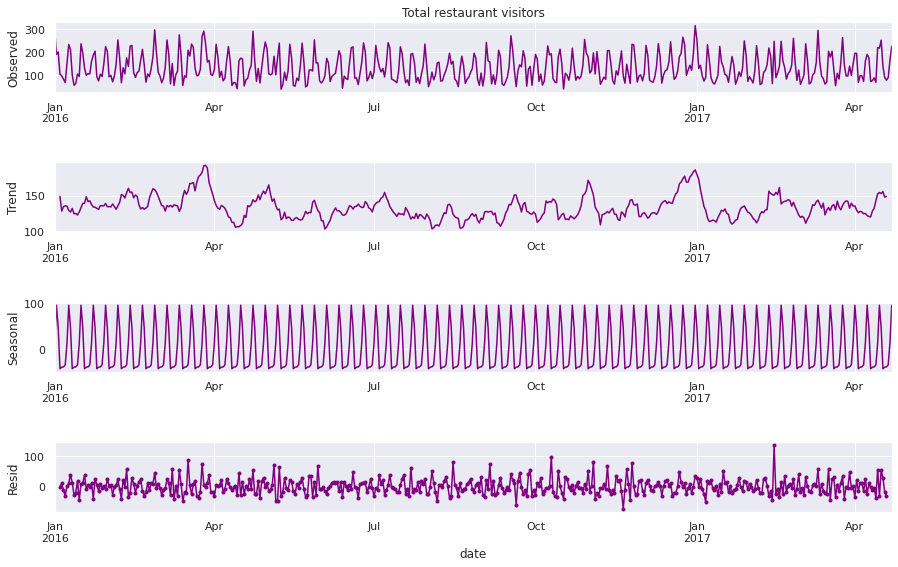

In [22]:
# Выполним ETS декомпозицию
decompos=seasonal_decompose(df_eda_nn['total'], model = 'additive')
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(15,9))
plt.subplots_adjust(hspace=1)
decompos.observed.plot(ax=axes[0], color='purple', ylabel='Observed', xlabel ='', title='Total restaurant visitors')
decompos.trend.plot(ax=axes[1], color='purple', ylabel='Trend', xlabel ='')
decompos.seasonal.plot(ax=axes[2], color='purple', ylabel='Seasonal', xlabel ='')
decompos.resid.plot(ax=axes[3], color='purple', marker='.', ylabel='Resid');

### Промежуточные выводы:


---


*Полученные графики демонстрируют наличие сезонности, что подтверждает верность выбора основной модели прогнозирования SARIMA. Также видно отсутствие тренда. *

---


### Построение моделей

---


*Рассматриваем прогноз SARIMA.*

---

In [23]:
# Запустим метод pmdarima.auto_arima, чтобы получить набор параметров для нашей модели
auto_arima(df_eda_nn['total'], seasonal=True, trace=True, m=7).summary() #включаем сезонность и указываем период сезонности = 1 неделя

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5269.484, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4916.749, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5049.644, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6126.084, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5200.790, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=4845.442, Time=1.34 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=5340.375, Time=1.69 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4788.447, Time=0.99 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=5058.642, Time=0.43 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=4950.814, Time=2.24 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=4982.776, Time=1.13 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=4770.250, Time=0.84 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2381.125
Date:                   Wed, 23 Mar 2022   AIC                           4770.250
Time:                           23:33:02   BIC                           4786.928
Sample:                                0   HQIC                          4776.807
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4774      1.408      2.469      0.014       0.717       6.238
ar.S.L7        0.9707      0.011     86.011      0.000       0.949       0.993
ma.S.L7       -0.7814      0.047    -16.596      0.000      -0.874      -0.689
sigma2      1219.6557     72.506     16.821      0.000    1077.546    1361.765
===================================================================================
Ljung-Box (L1) (Q):                  15.60   Jarque-Bera (JB):                72.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.78
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Промежуточные выводы:


---


*Лучшая модель по данному выводу - SARIMAX(0, 0, 0)x(1, 0, [1], 7). Используем ее для дальнейшего анализа.*

---


In [24]:
# Обучаем нашу модель SARIMA(0,0,0)(1,0,1,7) на train['total']
# Cоздаем модель с подобранными параметрами
model_sarimax = SARIMAX (train ['total'], order=(0,0,0), seasonal_order=(1,0,1,7))           
# Обучаем модель на обучающей выборке данных 
results_sarimax = model_sarimax.fit() 
# Проверяем результаты
results_sarimax.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  464
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2299.618
Date:                   Wed, 23 Mar 2022   AIC                           4605.237
Time:                           23:33:02   BIC                           4617.657
Sample:                       01-01-2016   HQIC                          4610.126
                            - 04-08-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9999   5.76e-05   1.74e+04      0.000       1.000       1.000
ma.S.L7       -0.9555      0.021    -44.652      0.000      -0.997      -0.914
sigma2      1089.0785     57.311     19.003      0.000     976.750    1201.407
===================================================================================
Ljung-Box (L1) (Q):                  11.42   Jarque-Bera (JB):                84.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.71
Prob(H) (two-sided):                  0.39   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Получаем прогнозируемые значения. Модель SARIMA(0, 0, 0)(1, 0, 1, 7)
start = len(train)
end = len(train)+len(test)-1
prediction_sarimax = results_sarimax.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0, 0, 0)(1, 0, 1, 7) Predictions')
# Выводим результаты
print ('\033[1m' + 'Прогнозируемые значения для адаптации модели' + '\033[0m', '\n')
print (prediction_sarimax)

Прогнозируемые значения для адаптации модели 

2017-04-09    174.294031
2017-04-10     89.922409
2017-04-11     95.770556
2017-04-12     97.414860
2017-04-13     96.009442
2017-04-14    146.247414
2017-04-15    228.923747
2017-04-16    174.284906
2017-04-17     89.917701
2017-04-18     95.765542
2017-04-19     97.409759
2017-04-20     96.004416
2017-04-21    146.239757
2017-04-22    228.911762
Freq: D, Name: SARIMA(0, 0, 0)(1, 0, 1, 7) Predictions, dtype: float64


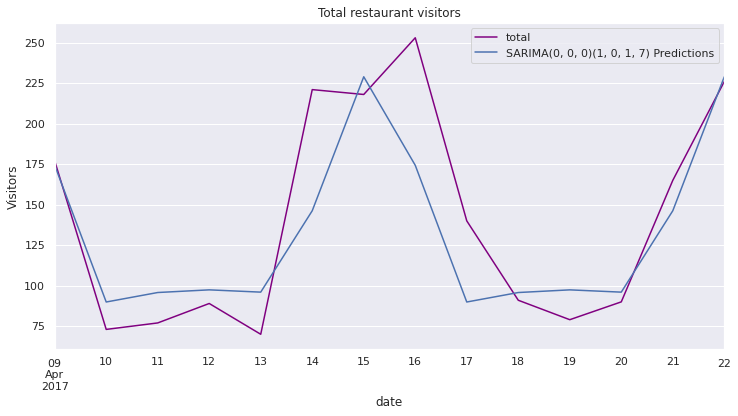

In [26]:
# Строим графики, где сравниваем прогнозные и тестовые выборки
df_eda_graph4=test['total'].plot(figsize=(12,6), title='Total restaurant visitors', ylabel='Visitors', legend=True, color='purple')
prediction_sarimax.plot(legend=True);
df_eda_graph4.autoscale(axis='x', tight=True)

In [27]:
# Оцениваем качество полученного прогноза на тестовой выборке с помощью метрик MSE, RMSE,  MAE и MAPE 
mse_value = mean_squared_error(test['total'], prediction_sarimax)  
rmse_value = rmse (test['total'], prediction_sarimax)
mae_value = mean_absolute_error(test['total'], prediction_sarimax)
mape_value = np.mean(np.abs(prediction_sarimax - test['total'])/test['total'])*100
# Выводим результат
print(f'Cреднеквадратичная ошибка (MSE), SARIMAX(0,0,0)x(1,0,[1],7):                       {mse_value:11.10}')
print(f'Квадратный корень из среднеквадратичной ошибки (RMSE), SARIMAX(0,0,0)x(1,0,[1],7): {rmse_value:11.10}')
print(f'Cредняя абсолютная ошибка (MAE), SARIMAX(0,0,0)x(1,0,[1],7):                       {mae_value:11.10}')
print(f'Cредняя абсолютная ошибка в процентах (MAPE), SARIMAX(0,0,0)x(1,0,[1],7):           {mape_value:11.10}')

Cреднеквадратичная ошибка (MSE), SARIMAX(0,0,0)x(1,0,[1],7):                       1183.072339
Квадратный корень из среднеквадратичной ошибки (RMSE), SARIMAX(0,0,0)x(1,0,[1],7): 34.39581863
Cредняя абсолютная ошибка (MAE), SARIMAX(0,0,0)x(1,0,[1],7):                       24.15347747
Cредняя абсолютная ошибка в процентах (MAPE), SARIMAX(0,0,0)x(1,0,[1],7):            17.8064484


In [28]:
# Натренируем модель на полном датасете и сделаем прогноз на 14 дней вперед 
# Создаем модель на полном датасете. Модель SARIMA(0, 0, 0)(1, 0, 1, 7)
teach_model_sarimax = SARIMAX (df_eda_nn['total'], order=(0,0,0), seasonal_order=(1,0,1,7))
# Обучаем модель
teach_results_sarimax = teach_model_sarimax.fit()
# Выводим результат
teach_results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2368.973
Date:                   Wed, 23 Mar 2022   AIC                           4743.946
Time:                           23:33:03   BIC                           4756.455
Sample:                       01-01-2016   HQIC                          4748.864
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        1.0000    4.8e-05   2.08e+04      0.000       1.000       1.000
ma.S.L7       -0.9617      0.021    -45.078      0.000      -1.003      -0.920
sigma2      1089.0905     57.361     18.987      0.000     976.665    1201.516
===================================================================================
Ljung-Box (L1) (Q):                  11.32   Jarque-Bera (JB):                86.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.72
Prob(H) (two-sided):                  0.43   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Получим предсказание на 14 дней вперед
fcast_sarimax = teach_results_sarimax.predict(len(df_eda_nn)-1, len(df_eda_nn)+13, typ='levels').rename('SARIMA(0, 0, 0)(1, 0, 1, 7) Forecast')  
# Выводим результат
print ('\033[1m' + 'Прогнозируемые значения на 14 дней вперед' + '\033[0m', '\n')
print (fcast_sarimax)

Прогнозируемые значения на 14 дней вперед 

2017-04-22    228.340168
2017-04-23    178.040041
2017-04-24     91.266485
2017-04-25     94.590976
2017-04-26     96.003049
2017-04-27     95.243338
2017-04-28    149.788638
2017-04-29    228.240818
2017-04-30    178.033116
2017-05-01     91.262935
2017-05-02     94.587296
2017-05-03     95.999315
2017-05-04     95.239633
2017-05-05    149.782812
2017-05-06    228.231940
Freq: D, Name: SARIMA(0, 0, 0)(1, 0, 1, 7) Forecast, dtype: float64


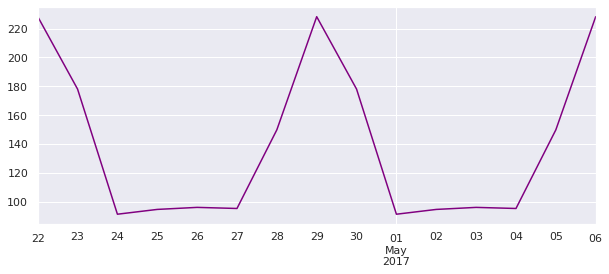

In [30]:
# Построим график предсказаний 
fcast_sarimax.plot(color='purple', figsize=(10,4));

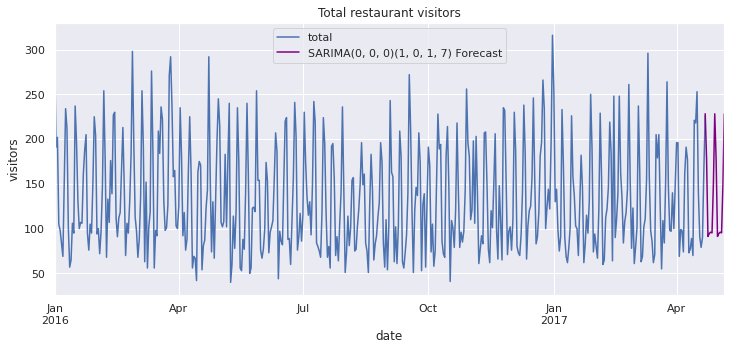

In [31]:
# Построим общий график с исходными и прогнозными значениями на 14 дней
df_eda_sarimax=df_eda_nn['total'].plot(figsize=(12,5), title='Total restaurant visitors', ylabel='visitors', legend=True)
fcast_sarimax.plot(legend=True, color='purple');

### Выводы по модели SARIMA:


---


*Полученные результаты являются удовлетворительными:*


1. По результатам видно примерное соответствие графиков прогнозной и тестовой выборок.     
2. Cредняя абсолютная ошибка в процентах = 18%, что также достаточно неплохо.
3. Модель предсказывает сохранение сезонности и стабильной посещаемости в последующие 2 недели.   

*Модель может быть использована в работе для дальнейшего прогнозирования*.


---

---


*Рассматриваем прогноз Prophet.*

---

In [32]:
# Датасеты обучающей и тестовой выборок проиндексированы по дате, поэтому для прямого обращения к атрибуту date сбросим индексы. 
# Сбрасываем индексы для обучающей выборки:
train_prophet = train.reset_index() 
# Сбрасываем индексы для тестовой выборки:
test_prophet = test.reset_index()
# Посмотрим преобразование после сброса индексов на примере обучающей выборки
train_prophet.head() 

,date,weekday,rest1,rest2,rest3,rest4,total
0,2016-01-01,Friday,65.0,25.0,67.0,139.0,296.0
1,2016-01-02,Saturday,24.0,39.0,43.0,85.0,191.0
2,2016-01-03,Sunday,24.0,31.0,66.0,81.0,202.0
3,2016-01-04,Monday,23.0,18.0,32.0,32.0,105.0
4,2016-01-05,Tuesday,2.0,15.0,38.0,43.0,98.0


In [33]:
# Создаем новые датасеты для выборок с атрибутами date и total
train_prophet_dt = train_prophet[['date','total']]
test_prophet_dt = test_prophet[['date','total']]
# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet.
# ds — временная гранула, в нашем случае дни
# y — значения, которые будем предсказывать, в нашем случае кол-во посетителей
train_prophet_dt.columns = ['ds', 'y'] 
test_prophet_dt.columns = ['ds', 'y'] 
# Проверим результат на примере обучающей выборки
train_prophet_dt.head()

,ds,y
0,2016-01-01,296.0
1,2016-01-02,191.0
2,2016-01-03,202.0
3,2016-01-04,105.0
4,2016-01-05,98.0


In [34]:
# Создаем модель Prophet
model_prophet = Prophet(seasonality_mode='multiplicative') 
# обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet_dt)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Промежуточные выводы:


---


*По результатам вывода алгоритм не учитывает годовую и дневную сезонность. Для учета годовой сезонности для модели необходимы данные за 2 года, а для дневной - данные по часам/минутам.*

---

In [35]:
# Задаем модели сделать новый датасет на 14 дней вперед
future_prophet = model_prophet.make_future_dataframe(periods=14)

In [36]:
# При помощи метода predict считаем прогноз и записываем в новую переменную:
prediction_prophet = model_prophet.predict(future_prophet)
# Проверяем результат
prediction_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-01,143.295394,119.097158,199.268494,143.295394,143.295394,0.106803,0.106803,0.106803,0.106803,0.106803,0.106803,0.0,0.0,0.0,158.599773
1,2016-01-02,143.226254,203.921282,287.390776,143.226254,143.226254,0.710869,0.710869,0.710869,0.710869,0.710869,0.710869,0.0,0.0,0.0,245.041384
2,2016-01-03,143.157114,154.230013,236.443768,143.157114,143.157114,0.345306,0.345306,0.345306,0.345306,0.345306,0.345306,0.0,0.0,0.0,192.590098
3,2016-01-04,143.087974,57.656979,138.302788,143.087974,143.087974,-0.324106,-0.324106,-0.324106,-0.324106,-0.324106,-0.324106,0.0,0.0,0.0,96.712246
4,2016-01-05,143.018835,62.627642,142.817497,143.018835,143.018835,-0.293697,-0.293697,-0.293697,-0.293697,-0.293697,-0.293697,0.0,0.0,0.0,101.014562




---


*Основные поля в прогнозе следующие:*

*ds — дата прогноза*

*yhat — спрогнозированное значение*

*yhat_lower — нижняя граница доверительного интервала для прогноза*

*yhat_upper — верхняя граница доверительного интервала для прогноза*


---



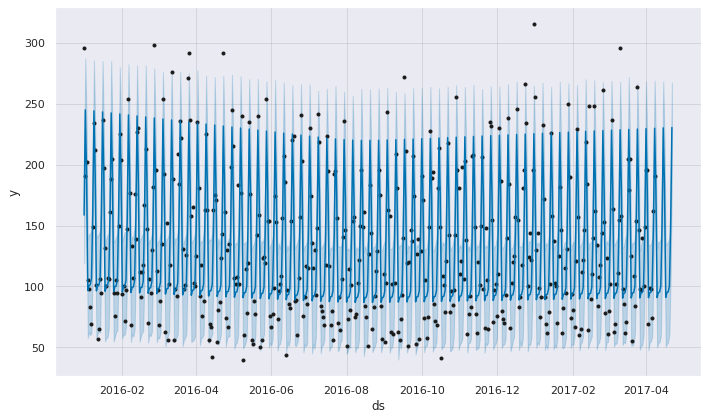

In [37]:
#При помощи метода plot сравниваем график по прогнозу и обучающей выборке (черные точки)
model_prophet.plot(prediction_prophet);

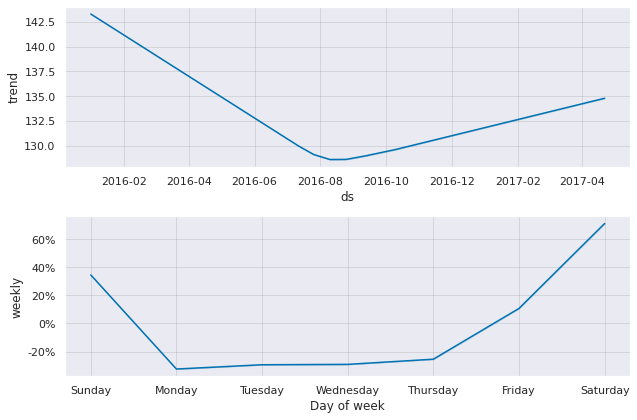

In [38]:
# Разложим наш временной ряд на компоненты тренда и сезонности
model_prophet.plot_components(prediction_prophet);

###Промежуточные выводы:

---


*Данный метод обнаруживает тренд - в период с 2016.02 по 2016.08 убывающий, далее тренд растет. Также обнаружена сезонность по дням недели.*

*Также подтверждается обнаруженная ранее корреляция:*

*- меньше всего посетителей приходятся на будни*

*- больше приходится на выходные дни.*


---



Оцениваем качество модели с помощью MSE, RMSE, MAE, MAPE

In [39]:
# Оцениваем качество полученного прогноза на тестовой выборке с помощью метрик MSE, RMSE,  MAE и MAP
mse_value = mean_squared_error(test_prophet_dt['y'], prediction_prophet['yhat'].tail(14))
rmse_value = rmse(test_prophet_dt['y'], prediction_prophet['yhat'].tail(14))
mae_value = mean_absolute_error(test_prophet_dt['y'], prediction_prophet['yhat'].tail(14))
mape_value = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet_dt['y'])/test_prophet_dt['y'])*100
# Выводим результат
print(f'Cреднеквадратичная ошибка (MSE), Prophet:                       {mse_value:11.10}')
print(f'Квадратный корень из среднеквадратичной ошибки (RMSE), Prophet: {rmse_value:11.10}')
print(f'Cредняя абсолютная ошибка (MAE), Prophet:                       {mae_value:11.10}')
print(f'Cредняя абсолютная ошибка в процентах (MAPE), Prophet:          {mape_value:11.10}')

Cреднеквадратичная ошибка (MSE), Prophet:                       1085.805793
Квадратный корень из среднеквадратичной ошибки (RMSE), Prophet: 32.95156738
Cредняя абсолютная ошибка (MAE), Prophet:                       23.80422457
Cредняя абсолютная ошибка в процентах (MAPE), Prophet:          64.49667323


In [40]:
# Получим предсказание на 14 дней вперед
# Тренируем модель на всем датасете
# Создаем модель
model_prophet_all = Prophet(growth = 'linear', weekly_seasonality = True, seasonality_mode='multiplicative') 
# Обучаем
model_prophet_all.fit(train_prophet_dt) 
# Создаем новый датасет с прогнозом на 14 дней вперед
future_prophet_all = model_prophet_all.make_future_dataframe(periods=14)
predict_prophet_all = model_prophet_all.predict(future_prophet_all)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


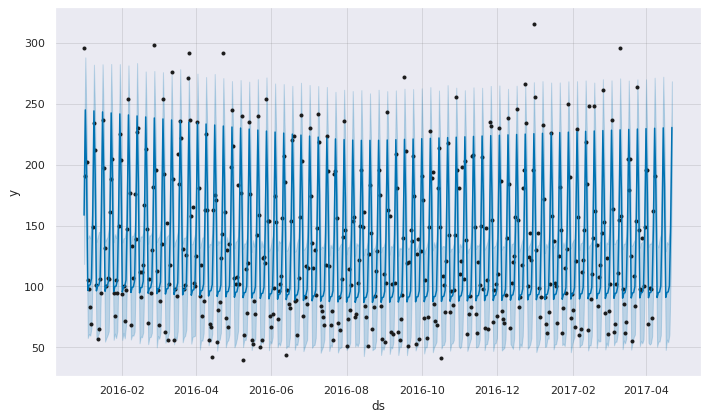

In [41]:
# При помощи метода plot сравниваем график по прогнозу и всей выборке (черные точки)
model_prophet_all.plot(predict_prophet_all);

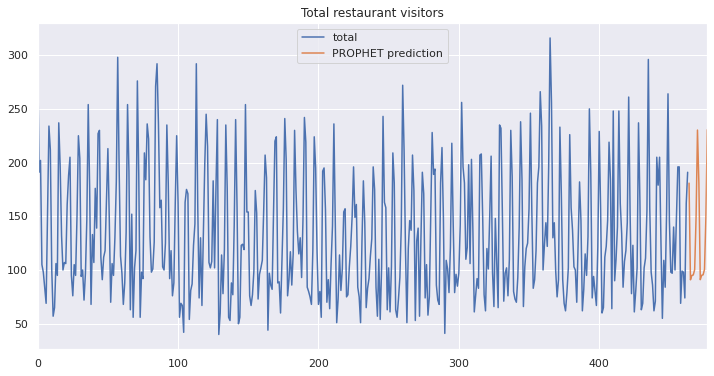

In [42]:
# Построим общий график с исходными и прогнозными значениями на 14 дней
ax = train_prophet_dt['y'].plot(legend=True, figsize=(12,6),title='Total restaurant visitors') 
predict_prophet_all['yhat'].tail(14).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["total", "PROPHET prediction"]);

### Выводы по модели Prophet:


---


*Полученные результаты в целом хуже чем по модели SARIMA:*


1. Cредняя абсолютная ошибка в процентах = 64%, против 18% по SARIMA.
3. При этом модель также обнаруживает сезонность.   

*Использование данной модели требует дополнительного изучения*.


---

---


*Рассматриваем модель "Экспоненциальное сглаживание" (Exponential smoothing).*

---

In [43]:
# Проверим исходную обучающую выборку
print('Кол-во строк в обучающей выборке:',len(train.index))

Кол-во строк в обучающей выборке: 464


In [44]:
# Проверим исходную тестовую выборку
print('Кол-во строк в тестовой выборке:',len(test.index))

Кол-во строк в тестовой выборке: 14


In [45]:
# Создаем модель ExponentialSmoothing с указанием параметров сезонности (неделя) и тренда:
model_expsmooth = ExponentialSmoothing(train['total'], seasonal_periods=7, trend = 'add')
# Обучаем модель на обучающей выборке данных
model_expsmooth.fit()

In [46]:
# Проверим подобранные параметры модели
model_expsmooth.params

{'damping_trend': nan,
 'initial_level': 128.33781621922176,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': -0.1567752292871556,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.0683510231645439,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.050317813834483326,
 'use_boxcox': False}

In [47]:
# Определяем интервал прогноза
print('начало прогноза:', test.index[0])
print('окончание прогноза:', test.index[-1])

начало прогноза: 2017-04-09 00:00:00
окончание прогноза: 2017-04-22 00:00:00


In [48]:
# Предсказываем значения, передав модели точки начала и окончания
prediction_expsmooth = model_expsmooth.predict(model_expsmooth.params, start=test.index[0], end=test.index[-1])
prediction_expsmooth

array([134.26399173, 134.32189043, 134.37978913, 134.43768783,
       134.49558652, 134.55348522, 134.61138392, 134.66928261,
       134.72718131, 134.78508001, 134.84297871, 134.9008774 ,
       134.9587761 , 135.0166748 ])

In [49]:
# Полученный массив преобразуем в датафрейм
prediction_expsmooth = pd.DataFrame(prediction_expsmooth)
# Индексируем массив по датам 
prediction_expsmooth.index = pd.date_range("2017-04-09 00:00:00", periods=14, freq="D")
# Обозначим имя колонки с прогнозами
prediction_expsmooth.columns = ['prediction_expsmooth']
# Проверим результат
prediction_expsmooth.head()

,prediction_expsmooth
2017-04-09,134.263992
2017-04-10,134.321890
2017-04-11,134.379789
2017-04-12,134.437688
2017-04-13,134.495587


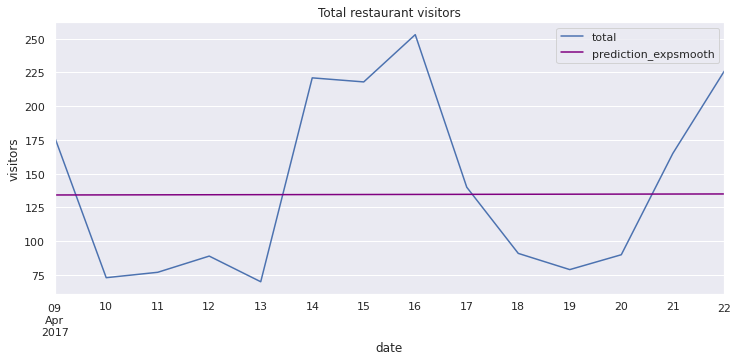

In [50]:
# Строим графики, где сравниваем прогнозные значения со значениями из тестовой выборки
test_graph=test['total'].plot(figsize=(12,5), title='Total restaurant visitors', ylabel='visitors', legend=True)
prediction_expsmooth['prediction_expsmooth'].plot(legend=True, color='purple');

In [51]:
# Оцениваем качество полученного прогноза на тестовой выборке с помощью метрик MSE, RMSE,  MAE и MAP
mse_value = mean_squared_error(test['total'], prediction_expsmooth['prediction_expsmooth'])
rmse_value = rmse(test['total'], prediction_expsmooth['prediction_expsmooth'])
mae_value = mean_absolute_error(test['total'], prediction_expsmooth['prediction_expsmooth'])
mape_value = np.mean(np.abs(prediction_expsmooth['prediction_expsmooth'] - test['total'])/test['total'])*100
# Выводим результат
print(f'Cреднеквадратичная ошибка (MSE), Exponential smoothing:                       {mse_value:11.10}')
print(f'Квадратный корень из среднеквадратичной ошибки (RMSE), Exponential smoothing: {rmse_value:11.10}')
print(f'Cредняя абсолютная ошибка (MAE), Exponential smoothing:                       {mae_value:11.10}')
print(f'Cредняя абсолютная ошибка в процентах (MAPE), Exponential smoothing:          {mape_value:11.10}')

Cреднеквадратичная ошибка (MSE), Exponential smoothing:                       4270.869171
Квадратный корень из среднеквадратичной ошибки (RMSE), Exponential smoothing: 65.35188728
Cредняя абсолютная ошибка (MAE), Exponential smoothing:                       59.31165102
Cредняя абсолютная ошибка в процентах (MAPE), Exponential smoothing:          48.63708515


In [52]:
# Получим предсказание на 14 дней вперед
# Тренируем модель на всем датасете
# Создаем модель с указанием параметров сезонности (неделя) и тренда:
teach_model_expsmooth = ExponentialSmoothing(df_eda_nn['total'], seasonal_periods=7, trend = 'add')
# Обучаем
teach_model_expsmooth.fit()

# задаем интервал начала и окончания в 14 дней
teach_fcast_expsmooth = teach_model_expsmooth.predict(teach_model_expsmooth.params, start=len(df_eda_nn)-1, end=len(df_eda_nn)+13)

# Преобразуем полученный массив в датафрейм с индексами по дате
teach_fcast_expsmooth = pd.DataFrame(teach_fcast_expsmooth)
teach_fcast_expsmooth.index = pd.date_range("2017-04-21", periods=15, freq="D")
teach_fcast_expsmooth.columns = ['teach_fcast_expsmooth']

# Проверяем результат
teach_fcast_expsmooth.head()

,teach_fcast_expsmooth
2017-04-21,135.058592
2017-04-22,142.434034
2017-04-23,142.924830
2017-04-24,143.415625
2017-04-25,143.906420


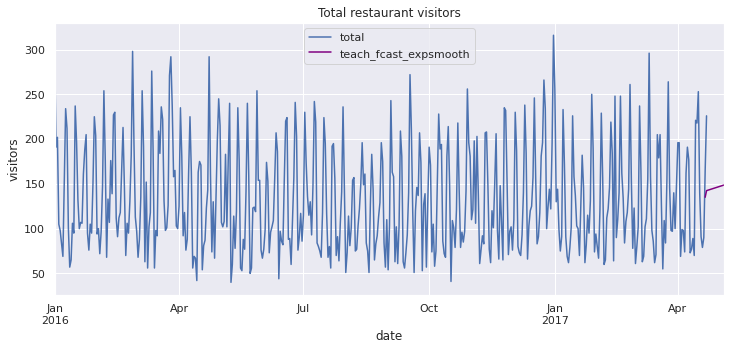

In [53]:
# Построим общий график с исходными и прогнозными значениями на 14 дней
df_eda_nn['total'].plot(figsize=(12,5), title='Total restaurant visitors', ylabel='visitors', legend=True)
teach_fcast_expsmooth['teach_fcast_expsmooth'].plot(legend=True, color='purple');

### Выводы по модели "Экспоненциальное сглаживание" (Exponential smoothing):


---


*Полученные результаты также в целом хуже чем по модели SARIMA:*


1. Cредняя абсолютная ошибка в процентах = 48%, против 18% по SARIMA.
3. При этом модель не показывает сезонность.   

*Использование данной модели для данного датасета нежелательно*.


---


## Общие выводы:

---


Для решения поставленных задач, выявить зависимости посещаемости от дней недели и спрогнозировать посещаемость на несколько дней вперед, были выполнены следующие шаги: 


* Проведена обработка и фильтрация исходных данных из полученного датасета;
* Произведен расчет и анализ статистических данных по основным атрибутам;
* Определены основные метрики (посещаемость ресторанов), построены графики временных рядов для данных метрик; 
* Проверена корреляция основных метрик; 
* Изучены прогнозы на 14 дней по 3 моделям (SARIMA, Prophet и Exponential smoothing).


По результатам анализа можно сделать следующие заключения:

* Подтверждена корреляция между изменением посещаемости и днями недели. Так на предоставленных данных подтвержден известный факт, что в выходные дни посещаемость значительно выше чем в будние - отмечается рост посетителей начиная с пятницы и по воскресенье. Пиковая посещаемость приходится на субботу.
* Среди изученных моделей лучшее качество прогнозирования показала модель SARIMA. Здесь были получены минимальные ошибки прогнозов по сравнению с моделями Prophet и Exponential smoothing. Поэтому для дальнейшей работы можно использовать именно эту модель. 
* Результаты прогнозов положительные с сохранением тенденций на сезонность и стабильную посещаемость. 






---